In [1]:

import sys  
sys.path.insert(0, '/Users/cwilson/desktop/programming/jupyter_tings/healthyride/healthyride')

from trip import Trip
from neighborhood_analytics.neighborhood import Neighborhood

import json


In [2]:
with open('../data.json') as f:
  json_list = json.load(f)
 

In [3]:
print(json_list[0])

{'Trip id': '15964640', 'Bikeid': '70029', 'To station name': "O'Hara St and University Place (Soldiers and Sailors Memorial)", 'Usertype': 'Subscriber', 'Stoptime': '4/1/2016 0:27', 'From station name': 'Maryland Ave & Ellsworth Ave', 'Starttime': '4/1/2016 0:17', 'To station id': '1040', 'Tripduration': '630', '_id': 1, 'From station id': '1031'}


In [4]:
#convert list of dicts to list of objects called "Trips"
Trip_list = []
for dict in json_list:
    li = list(dict.values())
    Trip_list.append(Trip(*li))

In [5]:
#test er out
print(Trip_list[420])
print(Trip_list[420].toname)
print(Trip_list[420].starttime)
print(Trip_list[420].weekday)
print(Trip_list[420].start_neighborhood)

Trip(tripid='16047764', bikeid='70252', toname='S 27th St & Sidney St. (Southside Works)', usertype='Customer', stoptime='4/3/2016 18:15', fromname='North Shore Trail & Fort Duquesne Bridge', starttime='4/3/2016 16:58', toid='1045', tripduration='4638', _id=417, fromid='1012')
S 27th St & Sidney St. (Southside Works)
4/3/2016 16:58
6
North Shore


In [6]:
print(len(Trip_list))

1022303


In [7]:
trip_tuple = Neighborhood.sort_direction_neighborhood_weekday_hour(Trip_list)

arrivals_by_neighborhood = trip_tuple[0]
departures_by_neighborhood = trip_tuple[1]


11


In [8]:
# print the 6th day of the week of arrivals by hour in oakland
print(arrivals_by_neighborhood['Oakland'][6])

{'5': Counter({'Oakland': 20, 'Not a station in a defined neighborhood': 9, 'East Liberty': 4, 'Shadyside': 2, 'Central Northside': 1, 'Southside Flats': 1, 'Downtown': 1, 'North Shore': 1}), '2': Counter({'Oakland': 81, 'Not a station in a defined neighborhood': 38, 'Shadyside': 21, 'Southside Flats': 7, 'East Liberty': 5, 'Downtown': 5, 'Squirrel Hill': 3, 'Central Northside': 1}), '6': Counter({'Oakland': 16, 'Downtown': 11, 'Not a station in a defined neighborhood': 11, 'Lawrenceville': 1}), '7': Counter({'Oakland': 32, 'Not a station in a defined neighborhood': 12, 'Shadyside': 7, 'Southside Flats': 7, 'East Liberty': 5, 'Downtown': 3, 'Strip District': 2, 'North Shore': 1}), '10': Counter({'Oakland': 177, 'Not a station in a defined neighborhood': 71, 'Shadyside': 34, 'Southside Flats': 27, 'Downtown': 23, 'East Liberty': 12, 'North Shore': 5, 'Lawrenceville': 5, 'Squirrel Hill': 5}), '12': Counter({'Oakland': 369, 'Not a station in a defined neighborhood': 91, 'Downtown': 46, 'S

In [9]:
# print the 6th day of the week of departures by hour in oakland
print(departures_by_neighborhood['Oakland'][6])

{'4': Counter({'Oakland': 13, 'Shadyside': 4, 'East Liberty': 4, 'Not a station in a defined neighborhood': 2, 'Lawrenceville': 1, 'Southside Flats': 1}), '2': Counter({'Oakland': 63, 'Not a station in a defined neighborhood': 19, 'Southside Flats': 11, 'Shadyside': 8, 'Downtown': 4, 'North Shore': 2, 'East Liberty': 2, 'Lawrenceville': 1, 'Strip District': 1}), '6': Counter({'Oakland': 25, 'Not a station in a defined neighborhood': 13, 'Shadyside': 11, 'East Liberty': 8, 'North Shore': 2, 'Squirrel Hill': 1}), '7': Counter({'Oakland': 25, 'Not a station in a defined neighborhood': 20, 'Shadyside': 6, 'East Liberty': 5, 'Southside Flats': 2, 'Downtown': 2, 'Squirrel Hill': 1}), '9': Counter({'Oakland': 127, 'Not a station in a defined neighborhood': 75, 'Shadyside': 38, 'East Liberty': 22, 'Downtown': 8, 'Lawrenceville': 8, 'Squirrel Hill': 4, 'Strip District': 3, 'Southside Flats': 2, 'North Shore': 2}), '11': Counter({'Oakland': 310, 'Not a station in a defined neighborhood': 98, 'Sh

In [10]:
#function that zips two dictionaries by identical key

def combine_dicts(arrival_dict, departure_dict):
    #order matters, arrivals are first index of tuple, departures follow
    return_dict = {}
    for key in arrival_dict.keys():
        return_dict[key] = (arrival_dict[key], departure_dict[key])
    return return_dict
        

In [11]:
tuple_dict = combine_dicts(arrivals_by_neighborhood, departures_by_neighborhood)

In [12]:
oakland = tuple_dict['Downtown']

In [13]:
from collections import OrderedDict

def make_keys_int(d):
    return_dict = {}
    for key in d.keys():
        return_dict[int(key)] = d[key]
    return return_dict


def order_nested_dict(nested_dict):
    return_dict = {}

    for key, val in OrderedDict(sorted(nested_dict.items())).items():
        nested_dict = make_keys_int(val)

        return_dict[key] = OrderedDict(sorted(nested_dict.items()))
    return return_dict


In [14]:
arrivals, departures = oakland

ordered_arrivals = order_nested_dict(arrivals)
ordered_departures = order_nested_dict(departures)

In [15]:
print(ordered_arrivals.keys())

dict_keys([0, 1, 2, 3, 4, 5, 6])


In [16]:
print(ordered_arrivals[0].keys())

odict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])


In [17]:
station_dict = {
    'Downtown': ['1000', '49701', '1002', '1001', '49691', '49671', '1056', '1003', 
                                '49731', '1004', '1006', '49651', '1010'],
    
    'Strip District': ['1016', '1017', '49611', '1059', '1060'],

    'East Liberty' : ['1026', '1027', '1029', '1024', '49391', '49371', '1064'],

    'Lawrenceville' : ['1061', '49581', '1019', '1020', '49501', '49951', '49561', '1018'],

    'North Shore' : ['49941', '49921', '1012', '1013'],

    'Central Northside' : ['1014', '1015', '49881'],

    'Southside Flats' : ['1074', '1049', '1048', '1047', '1046', '1045', '1084'],

    'Oakland' : ['1038', '1044', '1039', '1091', '1093', '1041', '1095', '1036', '1037', '1099', 
                        '1040', '1097', '1035', '1094', '49271'],
    
    'Squirrel Hill' : ['49251', '49261', '1068', '1069', '1070'],
    
    'Shadyside': ['1034', '1033', '1032', '1031'] 

}

In [18]:
station_list = list(station_dict.keys())
station_list.append('Not a station in a defined neighborhood')

In [19]:
arrival_daily_dict = {}
for day, val in ordered_arrivals.items():
    neighborhood_dict = {}
    for key, val in val.items():       
        for i in station_list:
            if i not in neighborhood_dict.keys():
                neighborhood_dict[i] = [val[i]]
            else:
                neighborhood_dict[i] += [val[i]]
    arrival_daily_dict[day] = neighborhood_dict


In [20]:
departure_daily_dict = {}
for day, val in ordered_departures.items():
    neighborhood_dict = {}
    for key, val in val.items():       
        for i in station_list:
            if i not in neighborhood_dict.keys():
                neighborhood_dict[i] = [val[i]]
            else:
                neighborhood_dict[i] += [val[i]]
    departure_daily_dict[day] = neighborhood_dict

In [21]:
print(departure_daily_dict.keys())

dict_keys([0, 1, 2, 3, 4, 5, 6])


In [22]:
print(departure_daily_dict[6])

{'Downtown': [142, 160, 79, 27, 21, 4, 37, 138, 250, 453, 704, 745, 776, 791, 862, 822, 780, 710, 696, 583, 415, 329, 266, 158], 'Strip District': [12, 9, 8, 0, 0, 3, 16, 13, 18, 72, 137, 180, 212, 198, 196, 196, 135, 109, 86, 40, 26, 14, 22, 5], 'East Liberty': [6, 0, 0, 0, 1, 0, 0, 2, 2, 3, 5, 10, 11, 9, 10, 3, 3, 6, 1, 4, 1, 0, 0, 0], 'Lawrenceville': [11, 9, 6, 0, 3, 3, 9, 14, 17, 60, 60, 65, 90, 69, 75, 38, 34, 51, 37, 33, 24, 11, 4, 3], 'North Shore': [30, 24, 20, 3, 4, 1, 2, 4, 30, 18, 55, 60, 50, 73, 99, 127, 174, 128, 109, 62, 47, 27, 22, 33], 'Central Northside': [1, 1, 0, 1, 2, 2, 3, 8, 15, 33, 26, 40, 42, 29, 23, 39, 36, 32, 27, 23, 9, 4, 0, 1], 'Southside Flats': [13, 8, 8, 4, 1, 9, 25, 17, 33, 85, 71, 109, 144, 151, 170, 171, 105, 93, 85, 65, 28, 30, 30, 7], 'Oakland': [1, 0, 6, 1, 0, 8, 6, 12, 37, 24, 26, 57, 54, 64, 58, 47, 49, 57, 27, 29, 7, 14, 14, 4], 'Squirrel Hill': [0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 1, 4, 1, 4, 0, 0, 0, 0, 0, 0], 'Shadyside': [1, 0, 2, 0, 

In [23]:
import matplotlib.pyplot as plt
from weekday_analytics.weekday import dayint_to_daystr




In [24]:
def plot_hours_of_day(ax, day_of_wk, daily_dict):
    

    x = list(range(0, 24))
    
    for key, val in daily_dict.items():
        ax[day_of_wk].title.set_text((dayint_to_daystr(day_of_wk)))
        
        ax[day_of_wk].plot(x, val)
        #ax.plot(x, val)

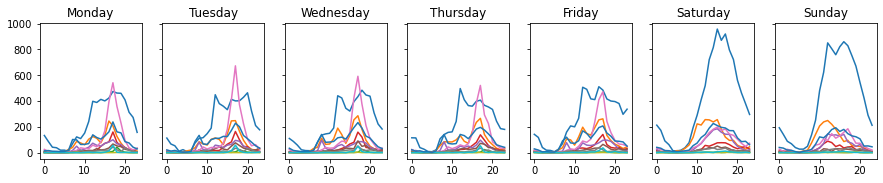

In [25]:
fig, axs = plt.subplots(1, 7, figsize=(15,2.5), sharey = True)
#note that at some point here arrivals are flipped with departures
for key, val in arrival_daily_dict.items():
    plot_hours_of_day(axs, key, val)

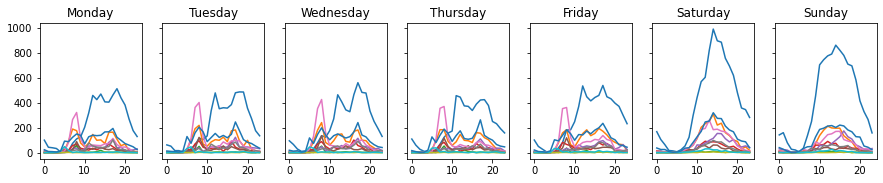

In [26]:
fig, axs = plt.subplots(1, 7, figsize=(15,2.5), sharey = True)
#note that at some point here arrivals are flipped with departures
for key, val in departure_daily_dict.items():
    plot_hours_of_day(axs, key, val)